# Desafio de Programação 4: Aplicação da DNN ao problema de localização em ambiente indoor utilizando cobertura Wi-Fi


## Identificação:

**Nome:** Gabriel Francisco de Oliveira Castro

**Matrícula:** 202066571


## 1. Introdução

Neste exercício, vamos aplicar uma Rede Neural Profunda (Deep Neural Network - DNN), que foi abordada no desafio anterior, a um problema do mundo real. Este problema consiste em utilizar a intensidade do sinal Wi-Fi recebido
(Received Signal Strength Indication - RSSI) por um dispositivo celular para determinar a sua posição dentro de um ambiente.


Todas as informações necessárias para resolver esta tarefa estão neste ambiente e todas as partes do código devem ser implementadas ao longo deste notebook.

Antes de iniciarmos o exercício, nós precisamos que algumas bibliotecas já estejam disponíveis. São elas:

- Numpy: (http://www.numpy.org/) para todas as operações matriciais;
- Matplotlib: (https://matplotlib.org/) para a plotagem dos gráficos;
- Scipy(https://docs.scipy.org/doc/scipy/reference/) que contém funções e ferramentas de cálculo numérico e científico.
- Pandas (https://pandas.pydata.org/) ferramenta de análise de dados que oferece estruturas de dados flexíveis para manipulação e análise de tabelas, séries temporais e conjuntos de dados de forma eficiente.
- Pytorch: (https://pytorch.org/docs/stable/index.html) que disponibiliza diversas funções que simplificam a criação de um modelo de inteligência artificial, acelerando a elaboração dos códigos.

Mas antes, nós configuraremos o ambiente, permitindo o acesso ao seu Google Drive, de onde será importado o dataset, além de outros módulos adicionais.


## 2. Preparação do Ambiente

A célula abaixo irá "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do Jupyter Notebook a partir, unicamente, da nuvem.

In [27]:
# allows the drive to be accessed
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [28]:
import sys

sys.path.append('/content/drive/MyDrive/UnB/Tópicos em Engenharia (IA e ML p  sist. de comunicações)/DP 4 - Tentativa 2')

Com o acesso permitido ao drive e com o ambiente preparado, podemos iniciar a importação das bibliotecas de Python que serão utilizadas no nosso código.

In [29]:
# Importing mathematical and scientific libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Importing specific optimization and special calculation functions
from scipy.optimize import minimize
from scipy.special import erfc, erfcinv
from scipy.integrate import quad

# Importing classes and functions related to PyTorch for data manipulation
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, TensorDataset

# Importing the torchvision library for computer vision tasks
import torchvision
import torchvision.transforms as transforms

# Importing Pandas for tabular data manipulation
import pandas as pd

import os
# used for manipulating directory paths

from sklearn.metrics import mean_squared_error

Antes de iniciarmos a implemetação do código de fato, vamos verificar se há alguma GPU disponível para rodar os códigos, com o intuido de tornar mais rápido o treinamento da DNN.

In [30]:
train_on_gpu = torch.cuda.is_available() # Check if the GPU is available
if train_on_gpu:
    device = torch.device('cuda') # Select device as GPU
    print("Treinando na GPU.")
else:
    device = torch.device('cpu') # Select device as CPU
    print("GPU indisponível, treinando na CPU.")

Treinando na GPU.


## 3. Descrição do Problema

Como previamente indicado, estaremos empregando uma DNN para abordar o problema da localização em ambientes internos, abrangendo locais como residências, apartamentos, edifícios e instalações industriais. Neste contexto, estaremos concentrando nossa análise em um andar específico de um edifício, o qual contém múltiplas salas.


Para uma melhor visualização, a imagem abaixo apresenta a configuração das salas do referido andar.

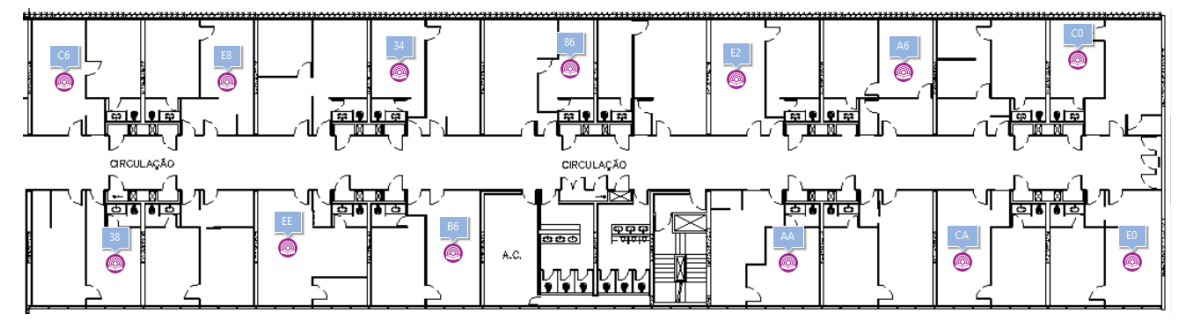

Além disso, a imagem acima também ilustra, em rosa, onde cada Access Point (AP), dispositivo responsável por transmitir o sinal Wi-Fi, está no ambiente. Ao todo, o andar possui 13 APs e uma área aproximada de 1215 m². Os APs são fixados no teto, a aproximadamente 2,1 metros de altura.

Com o cenário estabelecido, precisamos coletar as informações de potência recebida pelos dispositivos dos usuários (User Equipment - UE) em diferentes pontos do ambiente para a composição do dataset que permitirá treinar e testar a DNN. Para isso, foi realizado um [survey passivo](https://www.vhf.com.br/site-survey-o-que-e/#:~:text=O%20site%20survey%20passivo%20funciona,pontos%20e%20analisando%20o%20sinal.) no ambiente, no qual foi realizada a coleta de potência de cada um dos 13 APs em vários pontos do cenário.

Para construirmos o dataset, utilizamos um dispositivo dedicado para coletar informações de potência, também conhecida como RSSI, do sinal Wi-Fi. Quando esse dispositivo é conectado a um computador, ele transfere todas as medições, bem como as coordenadas do ponto de análise, para um arquivo de texto no formato CSV. Dessa forma, o arquivo conterá informações sobre a potência dos 13 pontos de acesso (APs) em cada um dos pontos de coleta de dados, juntamente com as respectivas coordenadas desses pontos no ambiente.

Os pontos em que as potências dos 13 APs foram coletadas estão ilustrados abaixo:

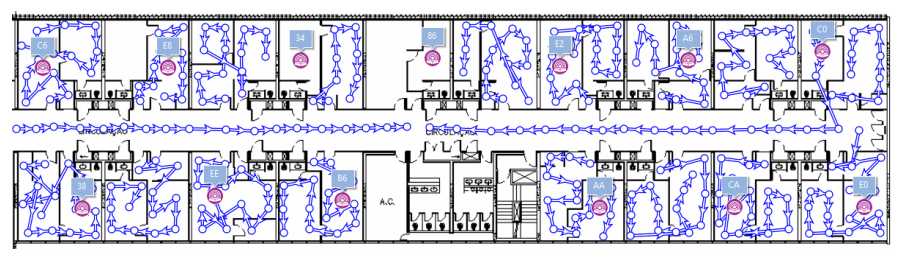

Na imagem acima, cada circulo refere-se a um ponto de coleta do RSSI. Ao todo, coletamos as informações descritas acima para 522 pontos.

## 4. DNN do problema

Agora, vamos definir a DNN que utilizaremos em nossa aplicação. Conforme foi abordado no desafio anterior, utilizaremos a biblioteca `Pytorch` com o intuito de simplificar e acelerar a  criação do modelo.

Iremos, portanto, começar importando o Pytorch no código.

In [31]:
import torch
from torch.utils.data import DataLoader, TensorDataset

### 4.1 Criação do modelo

Como foi descrito, o conjunto de dados que coletamos inclui as coordenadas do ponto em análise, juntamente com as potências dos 13 APs presentes no andar em questão. Nosso objetivo principal é utilizar essas informações de potência dos 13 APs em um ponto específico para estimar as coordenadas desse ponto. Para realizar essa tarefa, configuraremos nossa rede neural com 13 unidades de entrada, em que cada entrada representa a RSSI de um dos APs em determinado ponto de coleta de dados, e 2 unidades de saída, que representam as coordenadas (x, y) desse ponto.

Agora que definimos o número de unidades para a entrada e saída da nossa rede, o próximo passo é determinar quantas camadas ocultas e quantos neurônios teremos em cada uma dessas camadas. É importante lembrar que, ao ajustar essas quantidades, estamos influenciando a capacidade da rede de aprendizado. Geralmente, nosso objetivo é encontrar a configuração mais otimizada da rede, ou seja, aquela que requer o menor número de neurônios e camadas ocultas para alcançar uma boa precisão, uma vez que mais unidades e camadas resultam em maior carga computacional.

Para nossa aplicação, iniciaremos com duas camadas ocultas com 200 unidades, cada uma, e deseja-se obter resultados bastante acurados. O seu trabalho é determinar a menor quantidade de neurônios por camada que leve aos resultados desejados, que serão apresentados mais ao final do notebook. Para isso, iremos manter a quantidade de camadas inalterada, bem como, obviamente, a quantidade de neurônios nas camadas de entrada e de saída. Essa parte do Desafio de Programação vale **10 pontos**.

A estrutura da nossa rede neural será detalhada abaixo, em que temos uma camada de entrada, duas camadas ocultas e uma camada de saída. Construiremos agora essa rede utilizando o Pytorch. A estrutura dela é:
- Uma camada de entrada com função de ativação Linear com:

        -> Input: 13     
        -> Output: 200
        -> Bias: True
    
- Uma camada oculta com função de ativação ReLu com:

        -> Input: 200
        -> Output: 200
        -> Bias: True

- Uma camada oculta com função de ativação ReLu com:

        -> Input: 200
        -> Output: 2
        -> Bias: True
    
- E a camada de saída, também com função de ativação ReLu, que contém as saídas com as coordenadas do ponto analisado, logo, duas unidades.




Sendo assim, construiremos a nossa rede neural a partir da classe NeuralNetwork. Essa classe é inicializada definindo as funções `fc1`, `fc2` e `fc3` que executam transformações lineares nos dados em cada camada, sendo que a primeira ocorre na camada de entrada (com 13 entradas e 200 saídas), a segunda na camada oculta (com 200 entradas e 200 saídas) e a terceira, também na camada oculta (com 200 entradas e 2 saídas).

Na sequência definiremos a função forward() que executa a função ReLu como as funções de ativação das camadas em questão.

Na sequência definiremos a função forward(), responsável por receber a entrada e passá-la pelos neurônios para gerar uma saída, utilizando a função ReLU como as funções de ativação na saída das três camadas em questão.

A função de ativação ReLU (Rectified Linear Unit) é uma das funções de ativação mais amplamente usadas em redes neurais artificiais e aprendizado profundo. Ela é conhecida por sua simplicidade e eficácia na resolução de problemas de aprendizado de máquina e processamento de informações.

A função ReLU retorna o valor de entrada se esse valor for maior que zero e retorna zero se o valor for menor ou igual a zero. Portanto, a função é linear para valores positivos e retorna zero para valores negativos.

A principal razão pela qual a função ReLU é amplamente utilizada é devido à sua capacidade de superar o problema de valores baixos do gradiente, comum em certas funções de ativação, como a sigmoid e a tangente hiperbólica. Isso ocorre porque a derivada da função ReLU é simples de calcular e não se aproxima de zero na maior parte de seu domínio, permitindo valores efetivos de gradientes durante o treinamento de redes neurais profundas.

Além disso, a função ReLU é computacionalmente eficiente e rápida de calcular, o que a torna uma escolha prática em redes neurais profundas modernas. No entanto, é importante observar que a função ReLU pode levar a rede neural a apresentar alguns neurônios inativos (ou seja, sempre retornar zero) e não atualizar seus pesos durante o treinamento. Para combater esse problema, variantes da função ReLU, como a ReLU Inclinada (Leaky ReLU) e a Unidade Linear Exponencial (ELU), foram introduzidas. Caso você queira testar outra função de ativação, fique à vontade. Veja na literatura alguns exemplos interessantes. Mas lembre-se que a função de ativação na camada de saída deve ser adequada para o resultado desejado. No nosso caso, a ReLu tem essa propriedade. Pense um pouco sobre isso.

Em resumo, a função de ativação ReLU, cujo gráfico está ilustrado abaixo, é uma pedra angular em redes neurais profundas devido à sua eficácia, eficiência computacional e capacidade de superar o problema do desaparecimento de gradientes.

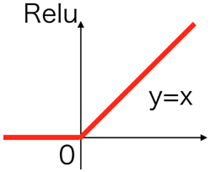

Com base na descrição acima da DNN a ser construída para resolver nosso problema, você deverá implementar todos os aspectos da rede abaixo.

A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total deste Desafio de Programação.

In [32]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # Camadas FC
    self.fc1 = torch.nn.Linear(13, 200)
    self.fc2 = torch.nn.Linear(200, 200)
    self.fc3 = torch.nn.Linear(200, 2)

  def forward(self, x):
    # Aplica a função ReLU em cada camada
    out = self.fc1(x)
    out = torch.nn.functional.relu(out)  # Função ReLU na camada 1

    out = self.fc2(out)
    out = torch.nn.functional.relu(out)  # Função ReLU na camada 2

    out = self.fc3(out)
    return out  # Camada de saída sem ativação (pode ser adicionada se necessário)



### 4.2 Processamento e tratamento dos dados de entrada

Quando estamos construindo um modelo de machine learning precisamos estimar o quão adequado ele é, baseado em alguma métrica. Adicionalmente, este teste de qualidade deve ser executado em dados que não foram usados no treinamento do modelo, assim poderemos medir a capacidade de generalização do modelo, observando o comportamento do modelo ao receber dados que nunca foram vistos.

Por isso, é recomendado dividir nossos dados em três partes, todas com o um objetivo específico. São elas:

- **Treinamento:** De forma resumida, é a porção dos dados que será utilizada para ajustar o modelo. Ou seja, são os dados que serão utilizados para treinar o modelo, adequando os valores dos pesos de cada aresta a partir da inserção desses dados.

- **Validação:** É a porção dos dados usada para fornecer uma avaliação imparcial, já que esses dados não serão utilizados para adequação dos parâmetros, medindo a capacidade de generalização da rede. Esse conjunto serve para verificar a necessidade de realizar ajustes do processo de treinamento da rede. Utiliza-se a validação para verificar se o modelo treinado não está tendo overfitting.

- **Teste:** É a porção dos dados usada para avaliar o modelo ao final de todo o treinamento, sem a intenção de ajustar mais nenhum ponto do modelo. Então, utilizamos os dados de teste quando queremos predizer novos resultados para o nosso modelo.

Mas o que é overfitting? Há dois cenários que são possíveis, mas não desejáveis, quando se treina uma rede: o overfitting e o underfitting.

O overfitting é um cenário onde o modelo tem um desempenho excelente nos dados de treinamento, mas não consegue repetir essa performance nos dados de validação. Podemos entender que, neste caso, o modelo aprendeu tão bem as relações existentes nos dados de treino, que acabou apenas decorando o que deveria ser feito nesses casos, de forma que, ao receber as informações ainda não vistas, o modelo não consegue generalizar e acaba tentando aplicar as mesmas regras decoradas que acabam não funcionando, afetando o seu desempenho.

Underfitting é um outro cenário onde o desempenho do modelo converge muito lentamente no próprio treinamento, de forma que o processo de aprendizagem termina e o modelo não consegue encontrar relações entre as variáveis.

A imagem abaixo mostra três comportamentos, um onde acontece o overfitting, outro é o que buscamos quando treinamos a rede e o ultimo é o caso onde acontece o underfitting.

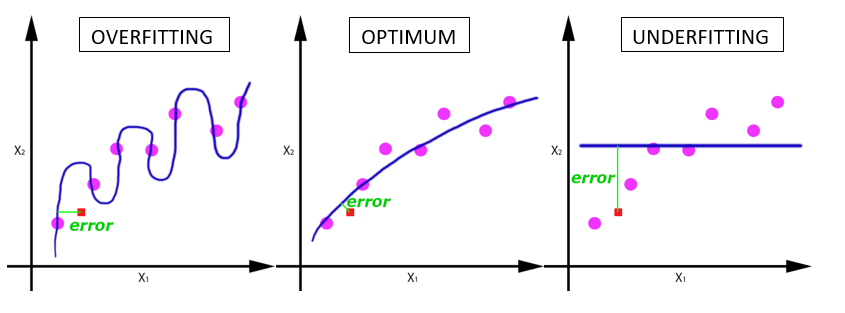

Em virtude da pouca quantidade de dados coletados, iremos separar o dataset apenas em dados para treino e uma outra parte para validação e teste.

Agora, procederemos com a importação do conjunto de dados, que é o arquivo CSV gerado após a realização do survey, utilizando a biblioteca `Pandas`. Após a leitura, executaremos uma operação de embaralhamento nos dados de posição, a fim de eliminar qualquer influência causada pela sequência original.

In [33]:
#df = pd.read_csv(os.path.join("/dataset", "rssi-dataset.csv"))
df = pd.read_csv(os.path.join("/content/drive/MyDrive/UnB/Tópicos em Engenharia (IA e ML p  sist. de comunicações)/DP 4 - Tentativa 2", "rssi-dataset.csv"))
df = df.iloc[:,1:]
df = df.sample(frac=1)

Vamos, antes de continuarmos, verificar como o dataset está organizado abaixo.

In [34]:
df.head()

,X,Y,2c5741f10e01,2c5741f11ca1,2c5741f11aa1,2c5741f0eb61,2c5741f29ee1,2c5741f5f381,2c5741f58c61,2c5741f0ee81,2c5741f0e341,2c5741f5d861,2c5741f5de21,2c5741f0fa61,2c5741f0ec01
429,156.565143,68.164857,-100,-100,-100,-81,-52,-58,-79,-59,-100,-100,-100,-100,-100
281,183.416000,63.365429,-100,-100,-73,-100,-100,-100,-100,-100,-75,-69,-100,-100,-100
358,172.779429,59.149714,-100,-100,-100,-57,-64,-100,-100,-100,-48,-61,-100,-100,-100
114,162.142857,58.825429,-100,-100,-100,-100,-51,-100,-100,-60,-63,-100,-100,-100,-100
353,183.545714,56.944571,-100,-100,-75,-100,-100,-100,-100,-100,-100,-61,-56,-76,-100


É possível ver que, para cada par de coordenada (x,y), temos a informação de potência para cada um dos 13 APs. O valor da potência coletada está em dBm, que é uma unidade de medida que expressa a potência absoluta mediante uma relação logarítmica (em decibéis) com base em 1 mW. Ou seja, 0 dBm equivale a 1 mW.

Logo, quanto maior é seu valor, significa que o determinado AP está mais próximo, fisicamente, do ponto analisado. Repare que existem muitos pontos em que a potência é `-100 dBm`. Certo?

**Isso tem uma explicação!**

Devido ao tamanho extremamente grande do andar, quando um ponto de coleta está muito distante de um AP, o valor de RSSI é tão pequeno que o equipamento de medição não é capaz de realizar a coleta de informação de potência (RSSI) desse AP naquele ponto. Para lidar com esses casos, implementamos um pré-processamento dos dados, onde definimos um valor de `-100 dBm` sempre que não conseguimos coletar informações de potência. Essa abordagem visa auxiliar a rede a reconhecer que essas potências compartilham uma característica comum, ou seja, indicam que o AP está distante do ponto em questão.

Uma vez criada a estrutura da rede neural, nós precisamos fazer o processamento dos dados de entrada, adequando-os para um formato em que a classe que criamos possa processá-los para fazer a aprendizagem dos parâmetros da rede.

Como os dados já foram importados, iremos transformá-los em tensores antes de criarmos o dataset. Para isso, nós utilizaremos os métodos torch.Tensor() e torch.LongTensor(). A diferença entre os dois é apenas a de que o primeiro aceita valores do tipo float (mais especificamente float32) enquanto o segundo aceita valores do tipo int (mais especificamente int64).

Além disso, vamos dividir esses dados em dois conjuntos distintos: um conjunto de teste e um conjunto de treinamento. Dado que já embaralhamos os dados durante a importação, agora só precisamos determinar a proporção de dados destinada a cada um dos conjuntos.

In [35]:
# Proporção de dados para teste, em %
test_proportion = 15

Um tratamento adicional que realizamos, dependendo do problema, é a normalização dos dados de entrada da rede. A normalização é um processo essencial para garantir que todas as características dos dados de entrada estejam na mesma escala. Isso é importante porque, em muitos algoritmos de aprendizado de máquina, as características com escalas diferentes podem afetar negativamente o desempenho do modelo. Normalizar os dados envolve ajustar as escalas para um intervalo comum, geralmente entre 0 e 1 ou -1 e 1, de modo que todas as características contribuam igualmente para o processo de aprendizado. Isso ajuda a rede neural a convergir mais rapidamente e a evitar problemas como a predominância de características de alta escala sobre as de baixa escala.

Para realizar a normalização dos dados, geralmente subtrai-se a média de cada característica e divide-se pelo desvio padrão. Isso é conhecido como Z-score normalization. Outra abordagem comum é a Min-Max normalization, onde os valores são escalados para um intervalo específico, como [0, 1].

A escolha entre esses métodos depende do problema específico e da distribuição dos seus dados. A normalização é uma etapa importante do pré-processamento de dados para redes neurais, pois pode melhorar significativamente o desempenho do modelo e ajudar a evitar problemas de convergência.

No contexto do nosso problema, optamos por utilizar a normalização Min-Max para preparar nossos dados. Agora, é necessário implementar a função responsável por realizar essa normalização nos dados de entrada. A implementação correta desta função contribuirá com **10 pontos** para a sua pontuação total neste Desafio de Programação.

In [36]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))

def min_max_scaler(input):
  # Cria um objeto MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0, 1))

  # Normaliza os dados de entrada
  normalized = scaler.fit_transform(input)

  return normalized


Vamos, finalmente, tratar e separar o dataset.

In [37]:
# Determining the number of test samples based on a given test proportion
test_num = int(test_proportion / 100 * len(df))

# Splitting input and output data into training and testing sets
# Converting the data to float32 data type
input_train, input_test = df.iloc[:-test_num, 2:].astype(np.float32).values, df.iloc[-test_num:, 2:].astype(np.float32).values
output_train, output_test = df.iloc[:-test_num, 0:2].astype(np.float32).values, df.iloc[-test_num:, 0:2].astype(np.float32).values

# Scaling the input data using a scaler (Min-Max)
input_train = min_max_scaler(input_train)
input_test = min_max_scaler(input_test)

# Converting the scaled data into PyTorch tensors
input_train, input_test = torch.Tensor(input_train), torch.Tensor(input_test)
output_train, output_test = torch.Tensor(output_train), torch.Tensor(output_test)

Feito isso, nós já podemos criar o nosso dataset que será utilizado no treinamento da rede neural. Para isso nós utilizaremos as funções TensorDataset e DataLoader. Mas antes é necessário definit o batch size. Nós iremos usar um valor inicial igual a 50, mas você deve experimentar outros valores e escolher um que permita um processo de otimização adequado. Para esse ajuste, você será pontuado em até **5 pontos**.

Nessas funções, nós selecionaremos o tamanho desejado para o batch, além da opção de embaralhar (shuffle) os dados para melhorar a performance da rede neural.

In [38]:
# Batch Size
batch_size = 50

# Creating datasets using the input and output tensors
dataset_train = TensorDataset(input_train, output_train)  # Training dataset
dataset_valid = TensorDataset(input_test, output_test)    # Validation dataset

# Creating data loaders for training and testing with specified batch sizes
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)  # Training data loader
dataloader_test = DataLoader(dataset_valid, batch_size=test_num, shuffle=True)     # Testing data loader

### 4.3 Treinamento e Validação da DNN

Para o treinamento da rede neural é preciso escolher qual função de custo será utilizada e qual será o algoritmo de otimização dos parâmetros da rede.

O Pytorch disponibiliza vários tipos de função de custo dentro do módulo `torch.nn`. Entre os mais conhecidos estão a *Cross Entropy* e o Erro Quadrático Médio (*mean squared error*). A documentação de todas essas funções de erro que o Pytorch fornece estão disponíveis [neste link](https://pytorch.org/docs/stable/nn.html#loss-functions).

Quanto ao algoritmo de otimização, a biblioteca também disponibiliza diversos tipos, entre os mais conhecidos estão o *Gradient Descedent*, o *Stochastic Gradient Descedent* e o Adam. A documentação destes e de outros algoritmos de otimização estão disponíveis [neste link](https://pytorch.org/docs/stable/optim.html#algorithms).

No nosso programa, os escolhidos foram a *Mean Squared Error* para função de custo e, como algoritmo de otimização, foi escolhido o Adam com valores iniciais de *learning rate* de 0.5 e, para os demais valores do otimizador, foram utilizados os valores default do algoritmo implementado em Pytorch. O seu trabalho é ajustar os valores dos parâmetros importantes do otimizador de forma adequada, e isso será pontuado com **20 pontos**. Para descobrir como ajustar esses parâmetros, comece estudando como essa função está implementada em Pytorch, por meio do link https://pytorch.org/docs/stable/generated/torch.optim.Adam.html. Será por meio do ajuste dos parâmetros da função torch.optim.Adam() que nós saberemos que você ajustou os parâmetros importantes do algoritmo Adam de forna adequada.

Com tudo configurado, podemos instanciar a nossa rede neural na variável `model`

In [39]:
# Instantiate the NN into variable model
model = NeuralNetwork()

# Definition of cost function
criterion = torch.nn.MSELoss()

# Definition of ADAM as optimizer algorithm and its parameter sets
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

Printaremos a variável `model` para que possamos visualizar os seus detalhes.

In [40]:
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=13, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=2, bias=True)
)


Uma vez que os dados de treino estão processados corretamente e o modelo está devidamente instanciado com função de custo e algoritmo de otimização configurados, devemos construir o loop de treinamento da rede.

Nós escolheremos, primeiramente, o número de épocas pelo qual a nossa rede neural passará nessa etapa de treinamento. Em cada uma dessas épocas, a rede neural deve criar outro loop em que cada exemplo do dataloader será explorado, calculando o erro e otimizando os parâmetros ao final de cada um desses exemplos.

Note que temos dois loop, sendo um destinado para o treino da rede e o outro para testar a rede durante o treinamento com os dados de validação. A sua tarefa é implementar o código que realize o treinamento no primeiro loop e o teste no segundo.

A correta implementação desta função lhe agregará **15 pontos** dentro da pontuação total deste Desafio de Programação.

In [41]:
epochs = 580

train_losses, valid_losses = [], []

for e in range(epochs):

    correct, total = 0, 0
    train_loss, valid_loss = 0, 0

    ###################
    # Train the model #
    ###################
    model.train()

    for RSSI, position in dataloader_train:

        # ====================== YOUR CODE HERE ======================
        optimizer.zero_grad()
        output = model(RSSI)
        loss = criterion(output, position)
        loss.backward()  # Backpropagate through the network
        optimizer.step()  # Update model weights based on gradients
        train_loss += loss.item()
        # ============================================================


    ######################
    # Validate the model #
    ######################
    model.eval()  # Prep model for evaluation

    for RSSI, position in dataloader_test:

        # ====================== YOUR CODE HERE ======================
        output = model(RSSI)
        loss = criterion(output, position)
        valid_loss += loss.item()
        torch.save(model.state_dict(), 'Modelo Treinado')

        # ============================================================

    else:
        train_loss = train_loss/len(dataloader_train)
        valid_loss = valid_loss/len(dataloader_test)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    if e % 5 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            e + 1, train_loss, valid_loss))

Epoch: 1 	Training Loss: 431334.130859 	Validation Loss: 1757.956299
Epoch: 6 	Training Loss: 96.628878 	Validation Loss: 75.023453
Epoch: 11 	Training Loss: 49.242624 	Validation Loss: 59.271248
Epoch: 16 	Training Loss: 41.324402 	Validation Loss: 48.981602
Epoch: 21 	Training Loss: 25.371451 	Validation Loss: 31.552259
Epoch: 26 	Training Loss: 22.454270 	Validation Loss: 27.207848
Epoch: 31 	Training Loss: 22.545605 	Validation Loss: 27.955605
Epoch: 36 	Training Loss: 19.142957 	Validation Loss: 23.826155
Epoch: 41 	Training Loss: 13.500357 	Validation Loss: 15.514816
Epoch: 46 	Training Loss: 12.632271 	Validation Loss: 14.211192
Epoch: 51 	Training Loss: 11.468048 	Validation Loss: 12.357788
Epoch: 56 	Training Loss: 10.773701 	Validation Loss: 11.104287
Epoch: 61 	Training Loss: 12.117690 	Validation Loss: 15.017385
Epoch: 66 	Training Loss: 13.424668 	Validation Loss: 13.063037
Epoch: 71 	Training Loss: 10.818158 	Validation Loss: 11.674582
Epoch: 76 	Training Loss: 11.695119 

Note que durante ao longo do processo de treinamento, temos a capacidade de monitorar o erro nos dados de treinamento e nos dados de teste. Essa prática é fundamental, pois nos permite avaliar se o modelo está convergindo de maneira adequada. O cenário ideal é aquele em que tanto o erro de treinamento quanto o erro de validação diminuem a cada época.

Com a rede treinada, podemos plotar os valores da função de custo em função do número de épocas, para que possamos analisar o comportamento dela e visualizarmos se houve a convergência esperada.

As célula abaixo plotarão os gráficos com a função de perda de treino e validação, respectivamente.

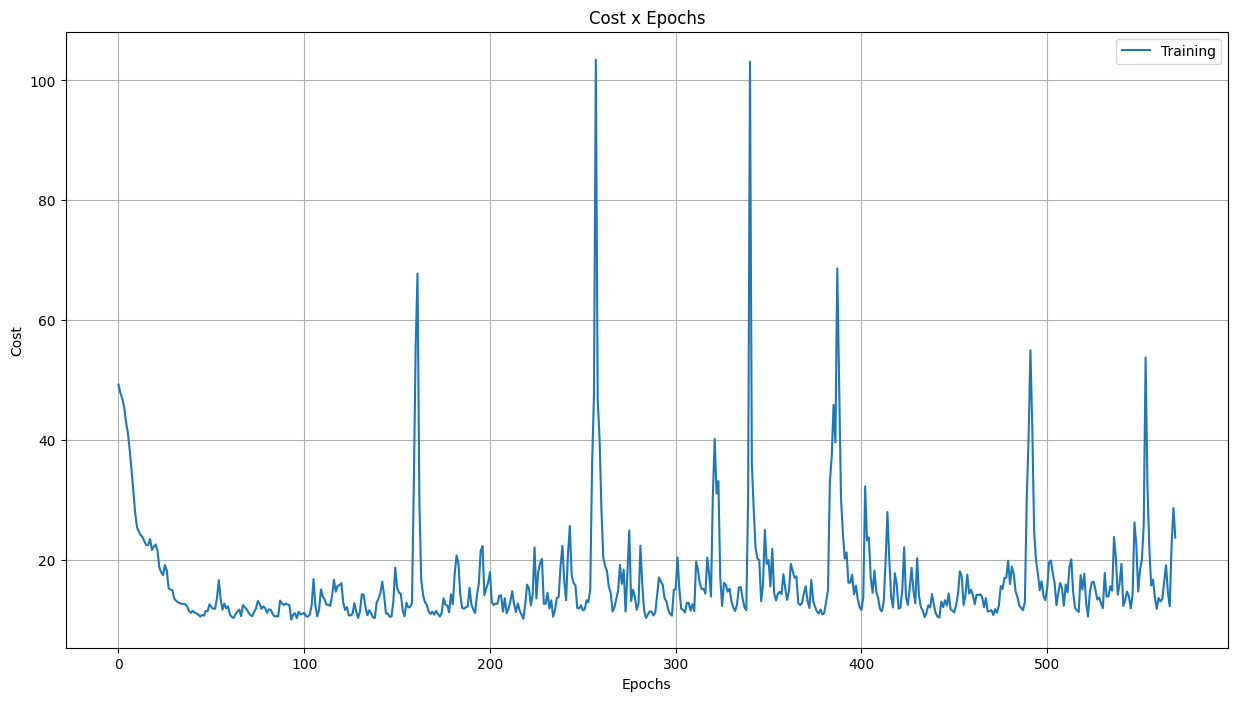

In [42]:
plt.figure(figsize=(15,8))
plt.plot(train_losses[10:], label='Training')
plt.title('Cost x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()
plt.show()

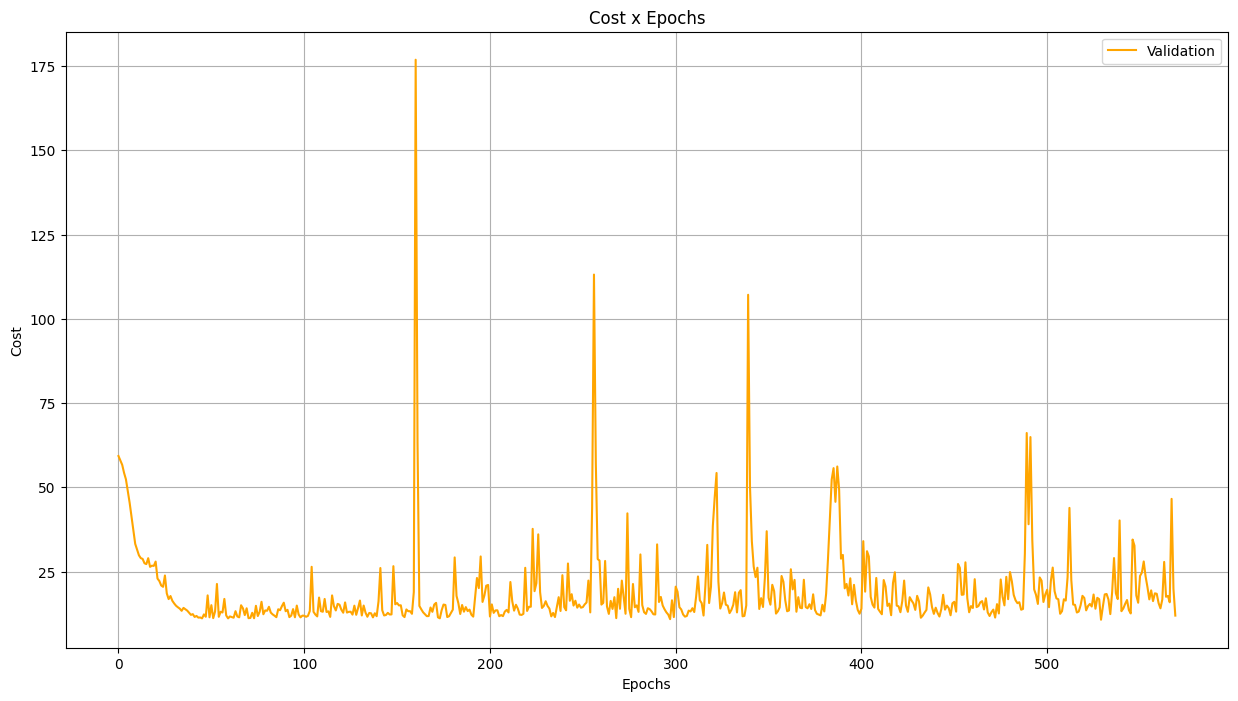

In [43]:
plt.figure(figsize=(15,8))
plt.plot(valid_losses[10:], label='Validation', color='orange')
plt.title('Cost x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()
plt.show()

A célula abaixo plotará os dois gráficos (da função de perda do treino e da função de perda da validação).

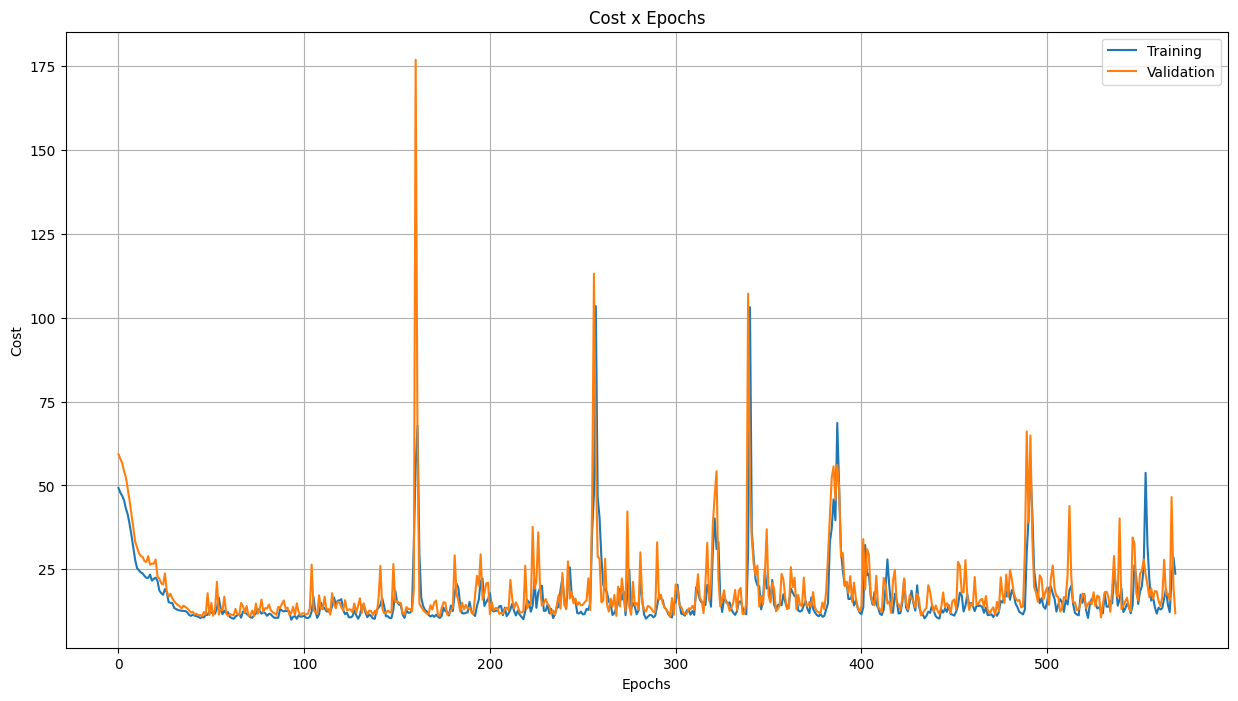

In [44]:
plt.figure(figsize=(15,8))
plt.plot(train_losses[10:],label='Training')
plt.plot(valid_losses[10:], label='Validation')
plt.title('Cost x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True)
plt.legend()
plt.show()

É importante notar que, ao analisar nosso conjunto de dados, enfrentamos desafios notáveis relacionados aos erros de treinamento e de validação. Para melhorar a visualização da evolução dos erros de treinamento e de validação e evitar distorção de nossa análise, optamos por não plotar os primeiros 10 erros.

Além disso, ao comparar os erros brutos entre os dois conjuntos, notamos uma diferença substancial na escala do erro. Essa discrepância é uma consequência direta da quantidade de registros presentes em cada conjunto de dados. Os dados de treinamento contêm consideravelmente mais amostras em comparação com os dados de validação, o que naturalmente resulta em erros totais maiores no conjunto de treinamento. No entanto, é importante destacar que essa escala de erro não deve ser interpretada como uma medida direta do desempenho do modelo em si, uma vez que ela está intrinsecamente relacionada ao tamanho do conjunto de treinamento. Portanto, é crucial adotar uma abordagem mais granular, considerando o erro médio por amostra, para realizar uma análise mais precisa e significativa do desempenho do modelo em ambos os conjuntos de dados.



Sabe-se que a escolha da quantidade de épocas de treinamento é fundamental para obter uma rede de desempenho adequado. Por isso, varie a quantidade de épocas e escolha um valor que seja adequado ao processo de treinamento da rede de Desafio de Programação. O ajuste adequado desse hiperparâmetro vale **10 pontos**.

### 4.4 Teste da Rede Treinada

Conforme já mencionado, deve-se realizar testes na rede treinada com dados que não pertencem ao conjunto de treinamento. Como já separamos os dados de validação, iremos utilizar eles para realizar o testes.

Para realizar o teste, é necessário carregar o modelo de rede que foi previamente treinado. Após a importação do modelo, o próximo passo é utilizá-lo para fazer previsões com base nos dados de validação. Portanto, a sua tarefa consiste em importar o modelo treinado e realizar a avaliação usando os dados de teste.

**ATENÇÃO:** Os valores estimados da rede neural ao serem aplicados nos dados de teste devem ser armazenados em uma variável chamada output_teste. Essa variável será usada nos blocos de código subsequentes.


A correta implementação desta função lhe agregará **10 pontos** dentro da pontuação total deste Desafio de Programação.

In [45]:
# ====================== YOUR CODE HERE ======================
model_teste = NeuralNetwork()
model_teste.load_state_dict(torch.load('Modelo Treinado', map_location=torch.device('cpu')))
model_teste.eval()
output_teste = []
# ============================================================

for RSSI, positions in dataloader_test:
# ====================== YOUR CODE HERE ======================
    output = model_teste(RSSI)
    output = output.clone().detach()
    output_teste.append(output)
# ============================================================


Para avaliarmos a precisão do nosso modelo, usaremos o
RMSE (Root Mean Square Error), ou Erro Quadrático Médio, que é uma métrica comumente usada para avaliar o desempenho de modelos de regressão ou previsão em tarefas de aprendizado de máquina. O RMSE mede a diferença entre os valores previstos pelo modelo e os valores reais dos dados. É uma medida da raiz quadrada da média dos quadrados das diferenças entre os valores previstos e os valores observados.

A fórmula do RMSE é a seguinte:

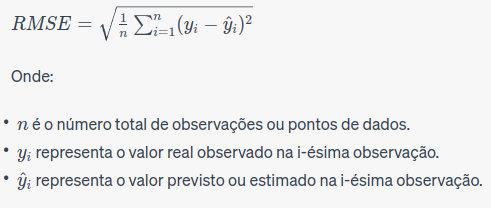

Dado que a biblioteca `Sklearn` já nos oferece essa função, vamos utilizá-la.

In [46]:
# Concatenar todos os tensores da lista output_teste em um único tensor
output_tensor = torch.cat(output_teste, dim=0)

In [47]:
# Calcular o RMSE para cada dimensão
RMSE_x = mean_squared_error(output_tensor[:,0].tolist(), positions[:,0].tolist(), squared=False)
RMSE_y = mean_squared_error(output_tensor[:,1].tolist(), positions[:,1].tolist(), squared=False)

Agora, vamos visualizar os erros.

In [48]:
print('Erro Quadrático Médio (RMSE) Eixo X: {:.6f} \nErro Quadrático Médio (RMSE) Eixo Y: {:.6f}'.format(
      RMSE_x,
      RMSE_y))

Erro Quadrático Médio (RMSE) Eixo X: 3.556729 
Erro Quadrático Médio (RMSE) Eixo Y: 3.346447


Repare que temos dois erros distintos, um para cada coordenada. Devido ao fato de que o eixo x do andar ser mais longo, é natural que tenhamos um erro maior nessa dimensão. Para uma compreensão mais abrangente, podemos consolidar esses erros em uma única medida de erro de distância.

Dessa maneira, temos que o erro é:

In [49]:
# Import math Library
import math

print('Erro Quadrático Médio (RMSE): {:.6f}'.format(
      math.sqrt(RMSE_x**2 + RMSE_y**2)))

Erro Quadrático Médio (RMSE): 4.883546


O erro devrá ficar em torno de 4 metros, ou menor.

Após obtermos o erro da rede neural, podemos prosseguir com uma análise mais detalhada desse erro e criar um gráfico de Função de Distribuição Cumulativa (CDF). A CDF nos fornece uma maneira de visualizar e compreender a distribuição do erro.

Vamos, antes, obter o erro geral, sem ser por coordenada, para cada um dos pontos de teste.

In [50]:
erros = []
for i in range(len(output_tensor[:, 0].tolist())):
    x = output_tensor[:, 0].tolist()[i] - positions[:, 0].tolist()[i]
    y = output_tensor[:, 1].tolist()[i] - positions[:, 1].tolist()[i]
    erro = math.sqrt(x**2 + y**2)
    erros.append(erro)


Agora, vamos plotar a CDF:

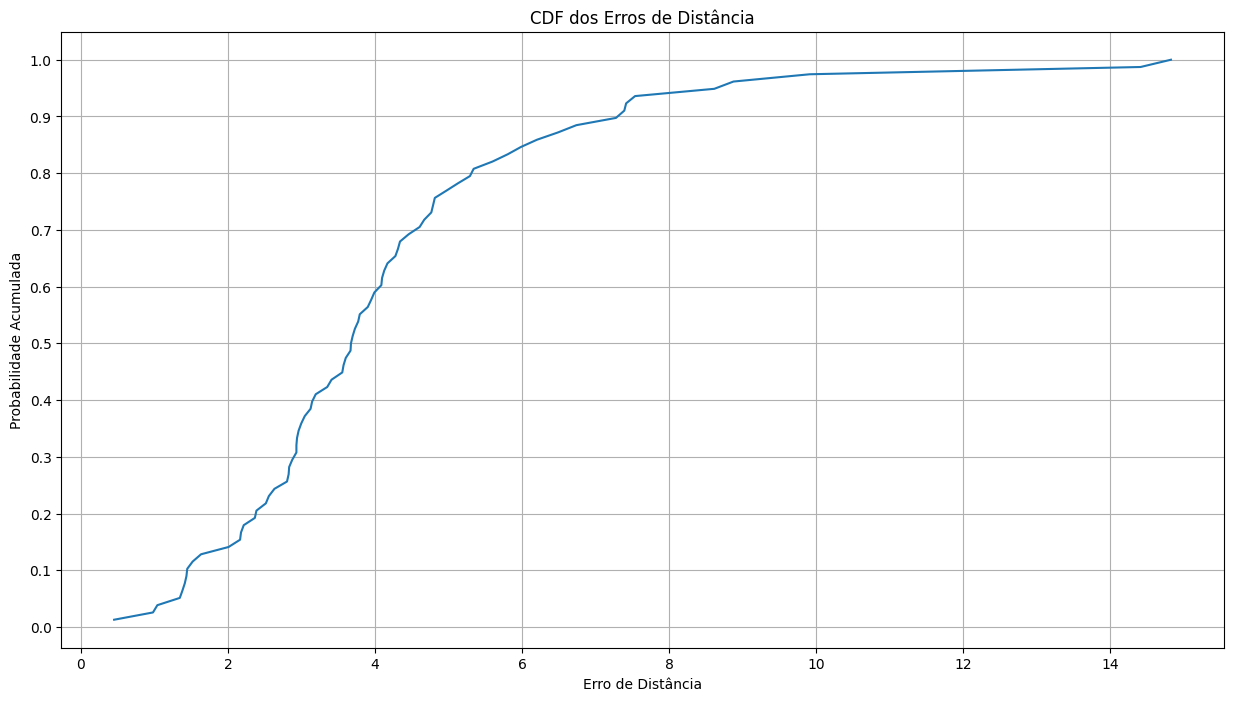

In [51]:
# Classify errors
erros_ordenados = np.sort(erros)

# calculate the CDF
cdf = np.arange(1, len(erros_ordenados) + 1) / len(erros_ordenados)

# Plot the CDF with a solid line
plt.figure(figsize=(15,8))
plt.plot(erros_ordenados, cdf)
plt.xlabel('Erro de Distância')
plt.ylabel('Probabilidade Acumulada')
plt.title('CDF dos Erros de Distância')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

A partir da CDF é possível determinar o percentual dos erros que estão abaixo de determinado valor. O seu trabalho é buscar os ajustes da rede neural que leve esse percentual a 90%. Ou seja, deseja-se uma rede neural treinada que apresente 90% dos erros de estimativa inferiores ou iguais a 5 metros, ou quem sabe você consiga um desempenho melhor. Obter esse desempenho lhe dará **10 pontos**.